In [1]:
import quantecon as qe
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy import optimize
import pandas as pd
from scipy.optimize import fsolve

#### Problem Set 5: Solving Aiyagari Model

##### Hasan Cetin, Lucas Belmudes

---

### The Problem

The Bellmann equation of the consumer is the following:

$$ T(V_n)(l,k) = \max_{k'} \left \{ \dfrac{(z-k')^{1-α}}{1-α} + \mathbb{E} \left \{ V_n(l',k') | l \right \} \right \}$$
$$\text{s.t.   } 0 \leq k' \leq z$$
$$\text{where   } z = wl + (1+r)k$$
$$w = (1-θ)\dfrac{K^{α}}{L}, \;\; r = θ \dfrac{K^{-α}}{L} $$

- Assume measure 1 of consumers

- We will assume $l$ is an i.i.d. idiosyncratic process centered at 1. (iid for simplicity, idiosyncracy by Aiyagari Model)

- Thus $L = 1$  and $w,r$ depends only on $K^D$: capital demand.

- $K^S$: capital supply is provided by the consumers/households.

- We will use EGM as in HW4 to solve the consumption-savings problem.

#### The algorithmus

1. Start $K^D$ from $K_{grid}$ and calculate prices $w,r$

2. Solve consumption-savings problem (we used EGM for efficiency) and get $V^*$ and corresponding $Γ^*$

3. Start a simulation for N agents starting from some $k_0$ by creating an $N$ x $T$ shock grid and use $Γ^*$ to simulate their path.
     -  NOTE: Use same shocks for each iteration!!!!!
     -  NOTE: Since this shock grid will use too much RAM size (if T = 20000, N = 1000, then size = 20000 x 1000 x 8 byte = 16 x $10^8$ = 1.6 GB), after calculating path, erase this shock grid and use a seed to create the same shock grid again.

4. $K^S = \dfrac{\sum_{i=1}^{N} k_i^T}{N}$

5. If $K^S > K^D$ increase $K^D$ (i.e. go to next value in the $K_{grid}$ for $K^D$)
     - NOTE: Check the following two cases first:
          - If $K^D > K^S$ even for $K^D = K_{grid}[0]$ then decrease your $K_{grid}$ immediately and start again.
          - If $K^D < K^S$ even for $K^D = K_{grid}[max]$ then increase your $K_{grid}[max]$ immediately and start again.
     - NOTE: If $K^D > K^S$ for some in $K_{grid}$ and $K^D < K^S$ for others in $K_{grid}$ but still no convergence, use finer $K_{grid}$

6. Iterate this process until market clearence: $max(|K^S - K^D|) < ϵ$

7. If no convergence, make your $K_{grid}$ finer.



In [229]:
# Define Parameters:

N = 100   # Number of agents for simulation
T = 20000 # Number of periods for simulation
n_k = 500 # Grids for capitals
n_A = 19  # Markov States.
α = 0.7   # Capital Share.
ρ = 0.95  # Memory of income
σ = 0.05   # Volatility of income.
γ = 2     # Risk aversion
β = 0.96  # Discont factor.
θ = 1     # Expanding grid coefficient.
error = 10e-6   # Error tolerance.
max_iter = 1000 # Maximum iteration

delta = 10e-4   #To differentiate the value function

np.random.seed(1234) #We are using a seed to generate the same shock grid each time

#Create aux variables for iteration
dist = 1000
iteration = 0

#Discretizing shocks
markov = qe.markov.approximation.rouwenhorst(n= n_A, ybar = 0, sigma=σ, rho= ρ)
Π = markov.P   
A = np.exp(markov.state_values)

#To be able to simulate the income shock process we will create cumulative prob matrix Π_sim
Π_sim = np.zeros((n_A, n_A))
for i in range(n_A):
    sum = 0
    for j in range(n_A):
        sum += Π[i,j] 
        Π_sim[i,j] = sum

# Maximum sustainable Capital:
K_max = 400
K_min = 0.01

# Use and expanding grid for more accuracy:
K_grid = K_min + (K_max - K_min) * (np.linspace(0, 1, n_k)**θ)

Check Kd such that $β(1+r) < 1$
Check $\bar A = Π_{ss} * A$ and in your w,r calculations 


In [230]:
for Kd_index, Kd in enumerate(K_grid[-1::-1]):
    #Calculate the prices first:
    w = (1-α)*(Kd**(α))
    r = α * (Kd**(α-1))
    
    #Given Prices, solve the consumption-saving problem:
    #Step 0: Some necessary matrices for EGM.
    V_k = np.zeros((n_A,n_k))
    c_star = np.zeros((n_A,n_k))
    Y_star = np.zeros((n_A,n_k))
    value = np.zeros((n_A,n_k))
    Realvalue = np.zeros((n_A,n_k))

    #Step 1: Creating on grid cash in hands matrix for tomorrow (i.e. z')
    Y_prime = np.zeros((n_A,n_k))
    for i in range(n_A):
        for j in range(n_k):
            Y_prime[i,j] = A[i]*w + K_grid[j]*(1+r)

    #Step 2: Initial guess
    V_0 = np.zeros((n_A,n_k))
    for i in range(n_A):
        for j in range(n_k):
            V_0[i,j] = ((A[i]*w + K_grid[j]*(1+r))**(1-γ))/(1-γ)

    #Finding the value function
    while dist > error and iteration < max_iter:
        for i in range(n_A):
            #Step 3: Doing the numerical derivative of the value matrix wrt k to get c_star
            V_spline = CubicSpline(K_grid,V_0[i,:])
            c_star[i,:] = ((V_spline(K_grid + delta) - V_spline(K_grid - delta))/ (2*delta))**(-1/γ)
        
        #Step 4: Finding Y_star (Today's cash in hands)
        Y_star = c_star + K_grid
        
        #Step 5: Finding corresponding values to the consumption
        Values = (c_star ** (1-γ))/(1-γ) + V_0
        
        for i in range(n_A):
            Y_i = Y_star[i,:]
            V_i = Values[i,:]

            #We need to sort Y_star to be able to interpolate
            sort_index = np.argsort(Y_i)
            Y_i_sorted = Y_i[sort_index]
            V_i_sorted = V_i[sort_index]

            #Step 6: Interpolate to get on grid values
            interpolation = CubicSpline(Y_i_sorted, V_i_sorted)
            Realvalue[i,:] = interpolation(Y_prime[i,:])

        #Step 7: Update your value
        V_1 = β * np.dot(Π, Realvalue)

        #Step 8: Check your
        dist = np.max(np.abs(V_1 - V_0))
        iteration += 1
        print("dist = ", dist)
        print("iteration = ", iteration)
        #Step 7: Update your value
        V_0 = V_1.copy()

        #Checking convergence of the value function
        if iteration > max_iter - 1:
            print("VFI does not converge")
            break

    #Step 8: Find the policy function
    k_policy = np.zeros((n_A,n_k))    #Real k'
    policy_index = np.zeros((n_A,n_k))#To find the index of policies for simulation
    for i in range(n_A):
        for j in range(n_k):
            def f(k, z=A[i], y_star=Y_star[i,j]):
                return z * k**α + (1-δ)*k - y_star
            k_policy[i,j] = fsolve(f,K_grid[0])
    #Step 9: Find the index matrix of the policy function for the simulation
    for i in range(n_A):
        for j in range(n_k):
            Grid = k_policy[i,j] - K_grid #We will use the closest point in K_grid to the real k'
            policy_index[i,j] = np.searchsorted(Grid,0)

    #Step 10: Simulation to find Ks
    #Create income shock simulation, need to use uniform rv to be able to use Π Markov Process
    Shock_sim = np.random.uniform(size=(N,T))
    
    #Create Income simulation (it gives the income shock indexes) and Policy simulation
    Income_sim = np.zeros((N,T+1))
    K_sim = np.zeros((N,T+1))
    
    #Assume each agent starts with mean income and 0 capital
    Income_sim[:,0] = n_A//2
    K_sim[:,0] = 0

    for n in range(N):
        for t in range(T):
            #Finding the income simulation
            new_shock = np.searchsorted(Π_sim[Income_sim[n,t],:], Shock_sim[n,t])
            Income_sim[n,t+1] = new_shock

            #In case np.searchsorted() function messes up
            #It is 0 possibility but if the uniform shock is exactly 1 then function messes up
            if new_shock >= n_A: 
                print("np.searchsorted is messed up!")
                break

            #Given income shock find the policy simulation
            K_sim[n,t+1] = policy_index[Income_sim[n,t],K_sim[n,t]]
  
    #Step 11: Calculate Ks
    Ks = np.sum(K_grid[K_sim[:,-1]])/N

    #Step 12: Check market clearence
    Diff = Ks - Kd 
    if Diff < 0:
        print("Ks < Kd")
        break
    elif Kd_index % 10 == 0:
        print("iteration: ", Kd_index)
        print("Difference: ", Diff)

    # If Market clears finish the program 
    if Diff < error:
        w_eq, r_eq = w, r #Equilibrium Prices
        Kd_eq = Kd        #Equilibrium Capital
        Sim_path_eq = K_sim #Simulation path in equilibrium prices
        break
    
    # To create a space in our beloved RAM, we erase this gigantic simulation grids. 
    del Shock_sim
    del Income_sim
    del K_sim

dist =  3.9138177176963547
iteration =  1
dist =  3.57566058272754
iteration =  2
dist =  3.1352812370631042
iteration =  3
dist =  2.7023360097517877
iteration =  4
dist =  2.300771544554877
iteration =  5
dist =  1.9374865753249146
iteration =  6
dist =  12.77238260951424
iteration =  7
dist =  232.6435904096321
iteration =  8


/var/folders/c_/9slv16s13p50vtr162z5f8th0000gn/T/ipykernel_97745/2567803530.py:31: RuntimeWarning: invalid value encountered in power
  c_star[i,:] = ((V_spline(K_grid + delta) - V_spline(K_grid - delta))/ (2*delta))**(-1/γ)


ValueError: `x` must contain only finite values.

Note that `np.searchsorted()` to find income shock is essentially wrong. Why? because let's say the uniform number is 0.68 and it is between to indexes in Π_sim of 0.67 and 0.7. `np.searchsorted()` would give the index of 0.67 but the correct index is of 0.7's because these are cumulative probabilities. But since we are using high N and T and since these type of cases are minimal, we ignore this problem.

In [109]:
# VFI with Howard (a.k.a PFI):
# Define Parameters:
N = 100         # Number of agents for simulation
T = 20000       # Number of periods for simulation
n_k = 1000       # Grids for capitals
n_A = 19        # Markov States.
α = 0.7         # Capital Share.
ρ = 0.95        # Memory of income
σ = 0.05         # Volatility of income.
σ_eps = np.sqrt(σ * (1-ρ**2)) #Standard deviation of the innovation
γ = 2           # Risk aversion
β = 0.96        # Discount factor.
δ = 1           # Depreciation rate
θ = 1           # Expanding grid coefficient.
error = 10e-6   # Error tolerance.
max_iter = 1000 # Maximum iteration
delta = 10e-4   # To differentiate the value function
λ = (1-β)/β     # Lambda

L = np.exp((σ_eps**2)/(2*(1-ρ**2))) # Labor size

Kd_min = ((1+λ)/α)**(1/(α-1)) * L # Min Kd 

# Use a seed to generate the same shock grid each time:
np.random.seed(1234) 

# Capital grid boundaries:
Ks_max = 20
Ks_min = 0.01

# Use and expanding grid to findd Capital Supply:
K_grid = Ks_min + (Ks_max - Ks_min) * (np.linspace(0, 1, n_k)**θ)

# Utility function
def U(c):
    if (c>=0).all()>0.0001:
        return ((c)**(1-γ))/(1-γ)
    else:
        return np.where(c <= 0.00001, -np.inf, -1*(c)**(-1))

# Discretizing the income shock:
markov = qe.markov.approximation.rouwenhorst(n= n_A, ybar = 1-ρ, sigma=σ, rho= ρ)

# Probability matrix and states:
# note that element (i,j) of P represents the transition probability
# of going to state "j" given that we are in state "i".
Π = markov.P   
A = markov.state_values  

# Steady state of transition matrix
Π_ss = Π.copy()
for i in range(1000):
    Π_ss =  np.dot(Π, Π_ss).copy()

# To be able to simulate the income shock process we will create cumulative prob matrix Π_sim
Π_sim = np.zeros((n_A, n_A))
for i in range(n_A):
    sum = 0
    for j in range(n_A):
        sum += Π[i,j] 
        Π_sim[i,j] = sum

# A flag variable to break the code if necessary
break_flag = False

In [110]:
Kd = Kd_min

# Step 1: Calculate the prices given Kd:
w = (1-α)*((Kd/L)**(α))
r = α * ((Kd/L)**(α-1)) - δ

# Step 2: Define initial values to calculate PFI:
V_0 = np.ones((n_A, n_k))
V_1 = np.copy(V_0)
Γ = np.ones((n_A, n_k), dtype=int)
iter = 0

# Step 3: Use PFI to find the value and policy function of the consumer given prices w,r
while iter < max_iter:
    # Finding Policy function
    for z in range(n_A):
        for k in range(n_k):
            V_1[z,k] = np.nanmax(U(A[z] * w + K_grid[k] * (1+r) - K_grid) + β * Π[z,:] @ V_0)
            Γ[z,k] = np.nanargmax(U(A[z] * w + K_grid[k] * (1+r) - K_grid) + β * Π[z,:] @ V_0)

    # Howard Steps
    m = 10 # Howard step size
    for i in range(m):
        for z in range(n_A):
            for k in range(n_k):
                V_1[z,k] = U(A[z] * w + K_grid[k] * (1+r) - K_grid[Γ[z,k]]) + β * Π[z,:] @ V_1[:,Γ[z,k]]        
    
    # Checking convergence
    if np.amax(np.abs(V_1 - V_0))< error:
        # print("Solution Found")
        # print(f'Iterations', iter)
        # print(f'Error', np.amax(np.abs(V_1 - V_0)))
        break
    elif iter % 5 == 0:
        print("dist: ",np.amax(np.abs(V_1 - V_0)))
    else:
        V_0 = np.copy(V_1)
        iter += 1
        if iter >= max_iter:
            break_flag = True
            break


dist:  181.0287743228124
dist:  181.0287743228124
dist:  181.0287743228124
dist:  181.0287743228124


KeyboardInterrupt: 

In [ ]:
# Simulation to find Ks
# Step 4: Create income shock simulation, need to use uniform rv to be able to use Π Markov Process
Income_sim = np.random.choice(np.arange(0,n_A), size=(N,T), p=Π_ss)

In [ ]:
K_sim = np.zeros((N,T+1)).astype(int)

In [ ]:
for n in range(N):
    for t in range(T):
        K_sim[n,t+1] = Γ[Income_sim[n,t], K_sim[n,t]]

In [ ]:


# Step 5: Create Income simulation grid (it gives the income shock indexes) and Policy simulation grid

K_sim = np.zeros((N,T+1)).astype(int)

# Assumption: Assume each agent starts with mean income and least capital possible
Income_sim[:,0] = int(n_A//2)
K_sim[:,0] = 0



# Given income shock find the policy simulation
K_sim[n,t+1] = Γ[Income_sim[n,t],K_sim[n,t]]

# Step 11: Calculate Ks
Ks = np.sum(K_grid[K_sim[:,-1]])/N

# Step 12: Check market clearence
Diff = Ks - Kd 
if Diff < 0:
    print(Diff)
    print("Ks < Kd")
    
elif Kd_index % 10 == 0:
    print("iteration of GE: ", Kd_index)
    print("Difference of GE: ", Diff)

In [81]:
w,r

(0.31698501589388417, 0.04166666666666674)

In [78]:

Income_sim = np.random.choice(np.arange(0,n_A), size=(N,T), p=Π_ss[0,:])

In [84]:
Γ

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])

In [80]:
Income_sim

array([[ 7, 10,  9, ..., 14, 14, 11],
       [ 9,  7,  8, ..., 11,  5,  7],
       [10,  7,  9, ..., 10,  5,  9],
       ...,
       [10,  7, 13, ...,  4,  6, 11],
       [ 6,  7,  8, ...,  8, 10, 11],
       [ 9,  7, 12, ..., 10, 14, 10]])

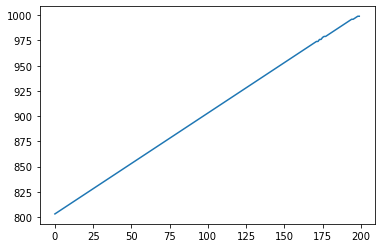

In [22]:


plt.plot(Γ[18,800:])


In [23]:
Γ[18,:]

array([  5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,
        18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,
        31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,
        44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,
        57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  67,  68,
        69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,
        82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,
        95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107,
       108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120,
       121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133,
       134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146,
       147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159,
       160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172,
       173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 18

In [ ]:
?plt.plot()

In [298]:
L = np.dot(Π_ss, A)

L

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1.])

As you can see, our labor supply is centered at 1, so we can cancel out L in w,r computations

From Aiyagari, we know that $r < \lambda \equiv \dfrac{(1-β)}{β}$

In [299]:
lam = (1-β)/β

In [300]:
(lam/α)**(1/(α-1))

12144.070294475914

In [2]:
# Finding GE
for Kd_index, Kd in enumerate(K[-1::-1]):
    # Step 1: Calculate the prices given Kd:
    w = (1-α)*(Kd**(α))
    r = α * (Kd**(α-1))

    # Step 2: Define initial values to calculate PFI:
    V_0 = np.ones((n_A, n_k))
    V_1 = np.copy(V_0)
    Γ = np.ones((n_A, n_k), dtype=int)
    iter = 0

    # Step 3: Use PFI to find the value and policy function of the consumer given prices w,r
    while iter < max_iter:
        # Finding Policy function
        for z in range(n_A):
            for k in range(n_k):
                V_1[z,k] = np.nanmax(U(A[z] * w + K[k] * (1+r) - K) + β * Π[z,:] @ V_0)
                Γ[z,k] = np.nanargmax(U(A[z] * w + K[k] * (1+r) - K) + β * Π[z,:] @ V_0)

        # Howard Steps
        m = 10 # Howard step size
        for i in range(m):
            for z in range(n_A):
                for k in range(n_k):
                    V_1[z,k] = U(A[z] * w + K[k] * (1+r) - K[Γ[z,k]]) + β * Π[z,:] @ V_1[:,Γ[z,k]]        
        
        # Checking convergence
        if np.amax(np.abs(V_1 - V_0))< error:
            # print("Solution Found")
            # print(f'Iterations', iter)
            # print(f'Error', np.amax(np.abs(V_1 - V_0)))
            break
        else:
            V_0 = np.copy(V_1)
            iter += 1
            if iter >= max_iter:
                break_flag = True
                break
    
    # If No convergence of the value function the program breaks
    if break_flag == True:
        print("No solution")
        break

    # Simulation to find Ks
    # Step 4: Create income shock simulation, need to use uniform rv to be able to use Π Markov Process
    Shock_sim = np.random.uniform(size=(N,T))
    
    # Step 5: Create Income simulation grid (it gives the income shock indexes) and Policy simulation grid
    Income_sim = np.zeros((N,T+1)).astype(int)
    K_sim = np.zeros((N,T+1)).astype(int)
    
    # Assumption: Assume each agent starts with mean income and least capital possible
    Income_sim[:,0] = int(n_A//2)
    K_sim[:,0] = 0

    for n in range(N):
        for t in range(T):
            # Finding the income simulation
            new_shock = np.searchsorted(Π_sim[Income_sim[n,t],:], Shock_sim[n,t])
            Income_sim[n,t+1] = new_shock.astype(int)

            # In case np.searchsorted() function messes up
            # It is 0 possibility but if the uniform shock is exactly 1 then function messes up
            if new_shock >= n_A: 
                print("np.searchsorted is messed up!")
                break

            # Given income shock find the policy simulation
            K_sim[n,t+1] = Γ[Income_sim[n,t],K_sim[n,t]]
  
    # Step 11: Calculate Ks
    Ks = np.sum(K_grid[K_sim[:,-1]])/N

    # Step 12: Check market clearence
    Diff = Ks - Kd 
    if Diff < 0:
        print(Diff)
        print("Ks < Kd")
        break
    elif Kd_index % 10 == 0:
        print("iteration of GE: ", Kd_index)
        print("Difference of GE: ", Diff)

    # If Market clears finish the program 
    if Diff < error:
        w_eq, r_eq = w, r # Equilibrium Prices
        Kd_eq = Kd        # Equilibrium Capital
        Sim_path_eq = K_sim # Simulation path in equilibrium prices
        break
    
    # To create a space in our beloved RAM, we erase this gigantic simulation grids. 
    del Shock_sim
    del Income_sim
    del K_sim
    


NameError: name 'K' is not defined

In [310]:
lam = (1-β)/β

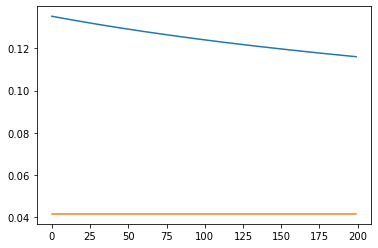

In [312]:
plt.plot(α*(K[-200:]**(α-1)))
plt.plot(lam * np.ones(K[-200:].shape))

In [256]:
np.searchsorted(Π_sim[3, :], Shock_sim[0,0])

3

In [257]:
Income_sim[3,5]

0.0